In [68]:
import glob
import os
from pathlib import Path
from collections import defaultdict

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

In [69]:
def find_csv_files(log_dir, algos, filename) -> list[Path]:
    # Matches …/<SEED>/debug/**/finetuning_eval.csv  (depth under debug doesn't matter)
    
    csv_files = dict()
    for algo, env_name, exp_log_dir in algos:
        pattern = os.path.join(log_dir, algo, exp_log_dir, "*", "debug", "**", filename)
        files = [p for p in glob.glob(pattern, recursive=True)]
        if env_name not in csv_files:
            csv_files[env_name] = {algo: files}
        else:
            csv_files[env_name][algo] = files 
    return csv_files


log_dir = "/n/fs/rl-chongyiz/exp_logs/ogbench_logs"
algos = [
    ("sarsa_ifql_vib_gpi_offline2offline", "cheetah_run", "20250504_sarsa_ifql_vib_gpi_offline2offline_cheetah_run_obs_norm=normal_alpha=0.3_num_fg=16_actor_freq=4_expectile=0.9_critic_z_type=prior_vf_time_emb=False_transition_ln=True_kl_weight=0.15_latent_dim=128"),
    ("fb_repr_fom_offline2offline", "cheetah_run", "20250507_fb_repr_fom_offline2offline_cheetah_run_obs_norm_type=normal_repr_alpha=10.0_alpha=0.3_num_fg=16_expectile=0.9_actor_freq=4_clip_fg=True"),

    ("sarsa_ifql_vib_gpi_offline2offline", "quadruped_jump", "20250504_sarsa_ifql_vib_gpi_offline2offline_quadruped_jump_obs_norm=normal_alpha=0.3_num_fg=16_actor_freq=4_expectile=0.9_critic_z_type=prior_vf_time_emb=False_transition_ln=True_kl_weight=0.005_latent_dim=128"),
    ("fb_repr_fom_offline2offline", "quadruped_jump", "20250507_fb_repr_fom_offline2offline_quadruped_jump_obs_norm_type=normal_repr_alpha=1.0_alpha=0.3_num_fg=16_expectile=0.9_actor_freq=4_clip_fg=True"),

    ("sarsa_ifql_vib_gpi_offline2offline", "walker_walk", "20250504_sarsa_ifql_vib_gpi_offline2offline_walker_walk_obs_norm=normal_alpha=0.3_num_fg=16_actor_freq=4_expectile=0.9_critic_z_type=prior_vf_time_emb=False_transition_ln=True_kl_weight=0.05_latent_dim=128"),
    ("fb_repr_fom_offline2offline", "walker_walk", "20250507_fb_repr_fom_offline2offline_walker_walk_obs_norm_type=normal_repr_alpha=1.0_alpha=0.3_num_fg=16_expectile=0.9_actor_freq=4_clip_fg=True"),
]

env_name_maps = {
    'cheetah_run': 'cheetah run',
    'quadruped_jump': 'quadruped jump',
    'walker_walk': 'walker walk',
}
algo_name_maps = {
    'sarsa_ifql_vib_gpi_offline2offline': 'InFOM (Ours)',
    'fb_repr_fom_offline2offline': 'FB + FOM',
    'hilp_fom_offline2offline': 'HILP + FOM',
}


csv_files = find_csv_files(log_dir, algos, filename="finetuning_eval.csv")

In [70]:
def load_data(csv_path, stat_name, step_name) -> np.ndarray:
    df = pd.read_csv(csv_path)
    if stat_name not in df.columns:
        raise KeyError(f"{csv_path} doesn't contain {stat_name}")
    x = df[step_name].values
    y = df[stat_name].values
    return dict(x=x, y=y)


algo_data = defaultdict(dict)
for env_name, env_csv_files in csv_files.items():
    for algo, csv_files in env_csv_files.items():
        seed_data = []
        for csv_file in csv_files:
            data = load_data(csv_file, "evaluation/episode.return", "step")
            if len(seed_data) == 0:
                seed_data.append(data["x"])
            else:
                assert np.all(data["x"] == seed_data[0])
            seed_data.append(data["y"])

        seed_data = np.asarray(seed_data)
        # steps = seed_data[0]
        # data = seed_data[1:]
        
        algo_data[env_name_maps[env_name]][algo_name_maps[algo]] = seed_data
        if len(seed_data) == 1:
            print("Warning: only one random seed!")

In [71]:
print(algo_data['cheetah run']['InFOM (Ours)'][0].shape)
print(algo_data['cheetah run']['InFOM (Ours)'][1:].shape)

(11,)
(5, 11)


/tmp/ipykernel_3155196/1813745280.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


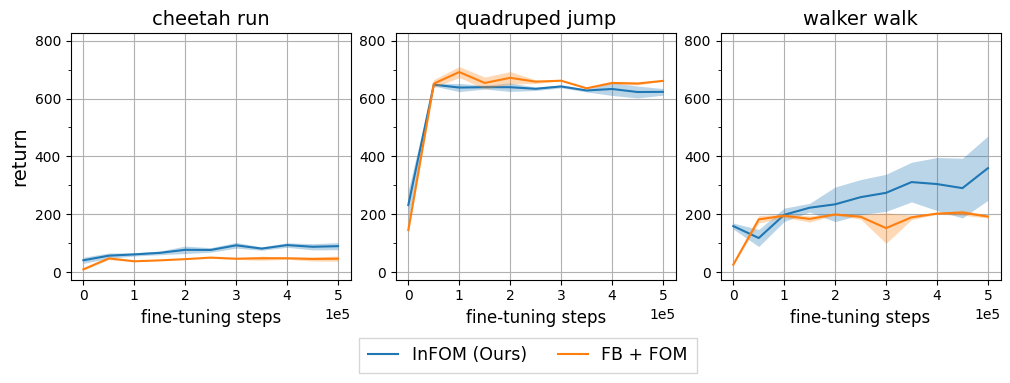

In [94]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3.2), gridspec_kw=dict(wspace=0.16, hspace=0.5))

for (env_name, env_data), ax in zip(algo_data.items(), axes):
    for algo, data in env_data.items():
        x = data[0] - 1e6
        y = data[1:]
        y_mean = np.mean(y, axis=0)
        y_std = np.std(y, axis=0, ddof=1)
        
        l, = ax.plot(x, y_mean, label=algo, zorder=3)
        ax.fill_between(x, y_mean - y_std, y_mean + y_std, alpha=0.3, lw=0, color=l.get_color(), zorder=3)

    if ax == axes[0]:
        ax.set_ylabel('return', fontsize=14)
        ax.legend(bbox_to_anchor=(1.0, -0.2),
            loc="upper left", labelspacing=1, columnspacing=1.8075, fancybox=False,
            shadow=False, fontsize=12.5, borderpad=0.5, handlelength=1.7, ncol=3)
    
    ax.set_title(env_name, fontsize=14)
    ax.set_xlim([- 2.5e4, 0.5e6 + 2.5e4])
    ax.set_ylim([-25, 825])
    ax.set_yticks([0.0, 200, 400, 600, 800])
    ax.set_xlabel('fine-tuning steps', fontsize=12)
    ax.yaxis.set_major_locator(MultipleLocator(200))
    ax.yaxis.set_minor_locator(MultipleLocator(100))
    ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))  
    
    ax.grid(zorder=3)     

fig.tight_layout()
filepath = "/u/cz8792/research/ogbench/plot_scripts/figures/intention_encoding_ablation_lc.pdf"
fig.savefig(filepath, dpi=150, bbox_inches="tight")
plt.show()
